In [1]:
import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
# from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime
from babi_joint import BabiDataset, pad_collate
from torch.utils.data.dataset import Dataset
from glob import glob
from perceiver_pytorch.perceiver_io_gated import PerceiverIObAbInq
import time

In [2]:
# UT pondernet 1470003

model = PerceiverIObAbInq(
    num_tokens=179,
    context_max_seq_len=71*13,
#     question_max_seq_len=13,
    dim = 32,                    # dimension of sequence to be encoded
    queries_dim = 179,            # dimension of decoder queries
#     logits_dim = 50,            # dimension of final logits
    depth = 20,                   # depth of net
    num_latents = 32,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 64,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    weight_tie_layers = True,   # whether to weight tie layers (optional, as indicated in the diagram)
    self_per_cross_attn = 1,     # number of self attention blocks per cross attention
    learn_latents=True
)

model_name = 'perceiverIO_bAbi_nq_deep_gru'
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

476972


In [3]:
batch_size=128
max_epochs = 150

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
vocab_size = len(babi_dataset.QA.VOCAB)
print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = float('inf')

writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')
now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")

for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    loss_sum = 0
    loss_count = 0
    model.train()
    babi_dataset.set_mode('train')
    train_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
    )
    
    for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()

        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)
        
        logits = torch.squeeze(model(torch.cat((contexts, questions), 1)))
        loss = criterion(logits, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        writer.add_scalars("losses_step", {"train_loss": loss.item() / contexts.size(0)}, epoch * len(train_loader) + batch_idx)
    
    train_loss = train_loss / len(train_loader.dataset)
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    train_loader_len = len(train_loader)
    
    model.eval()
    babi_dataset.set_mode('valid')
    val_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        
            contexts, questions, answers, tasks = data
            contexts = contexts.long().to(device)
            questions = questions.long().to(device)
            answers = answers.to(device)
        
            logits = torch.squeeze(model(torch.cat((contexts, questions), 1)))
            loss = criterion(logits, answers)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader.dataset)
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * train_loader_len - 1)    
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss

len(babi_dataset) train 180000
vocab_size 179
cuda:0


Epoch 1/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.053622 	Validation Loss: 1.351019
Validation loss decreased (inf --> 1.351019).  Saving model ...


Epoch 2/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.206293 	Validation Loss: 1.126462
Validation loss decreased (1.351019 --> 1.126462).  Saving model ...


Epoch 3/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.054029 	Validation Loss: 1.019985
Validation loss decreased (1.126462 --> 1.019985).  Saving model ...


Epoch 4/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.984823 	Validation Loss: 0.967610
Validation loss decreased (1.019985 --> 0.967610).  Saving model ...


Epoch 5/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.943906 	Validation Loss: 0.935952
Validation loss decreased (0.967610 --> 0.935952).  Saving model ...


Epoch 6/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.915757 	Validation Loss: 0.929455
Validation loss decreased (0.935952 --> 0.929455).  Saving model ...


Epoch 7/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.894853 	Validation Loss: 0.900009
Validation loss decreased (0.929455 --> 0.900009).  Saving model ...


Epoch 8/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.878052 	Validation Loss: 0.879919
Validation loss decreased (0.900009 --> 0.879919).  Saving model ...


Epoch 9/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.861987 	Validation Loss: 0.863609
Validation loss decreased (0.879919 --> 0.863609).  Saving model ...


Epoch 10/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.848647 	Validation Loss: 0.846190
Validation loss decreased (0.863609 --> 0.846190).  Saving model ...


Epoch 11/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.836462 	Validation Loss: 0.838385
Validation loss decreased (0.846190 --> 0.838385).  Saving model ...


Epoch 12/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.824603 	Validation Loss: 0.841144


Epoch 13/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.815193 	Validation Loss: 0.823994
Validation loss decreased (0.838385 --> 0.823994).  Saving model ...


Epoch 14/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.807490 	Validation Loss: 0.828253


Epoch 15/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.800641 	Validation Loss: 0.819821
Validation loss decreased (0.823994 --> 0.819821).  Saving model ...


Epoch 16/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.794438 	Validation Loss: 0.819006
Validation loss decreased (0.819821 --> 0.819006).  Saving model ...


Epoch 17/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.787769 	Validation Loss: 0.807182
Validation loss decreased (0.819006 --> 0.807182).  Saving model ...


Epoch 18/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.783292 	Validation Loss: 0.804484
Validation loss decreased (0.807182 --> 0.804484).  Saving model ...


Epoch 19/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.776726 	Validation Loss: 0.804026
Validation loss decreased (0.804484 --> 0.804026).  Saving model ...


Epoch 20/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.772108 	Validation Loss: 0.799206
Validation loss decreased (0.804026 --> 0.799206).  Saving model ...


Epoch 21/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.767996 	Validation Loss: 0.796919
Validation loss decreased (0.799206 --> 0.796919).  Saving model ...


Epoch 22/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.764709 	Validation Loss: 0.788858
Validation loss decreased (0.796919 --> 0.788858).  Saving model ...


Epoch 23/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.760905 	Validation Loss: 0.797370


Epoch 24/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.757062 	Validation Loss: 0.788022
Validation loss decreased (0.788858 --> 0.788022).  Saving model ...


Epoch 25/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.753960 	Validation Loss: 0.791655


Epoch 26/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.750515 	Validation Loss: 0.786852
Validation loss decreased (0.788022 --> 0.786852).  Saving model ...


Epoch 27/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.748029 	Validation Loss: 0.781993
Validation loss decreased (0.786852 --> 0.781993).  Saving model ...


Epoch 28/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.744229 	Validation Loss: 0.785547


Epoch 29/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.741407 	Validation Loss: 0.787846


Epoch 30/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.737951 	Validation Loss: 0.782102


Epoch 31/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.734798 	Validation Loss: 0.778078
Validation loss decreased (0.781993 --> 0.778078).  Saving model ...


Epoch 32/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.733005 	Validation Loss: 0.783251


Epoch 33/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.730523 	Validation Loss: 0.777237
Validation loss decreased (0.778078 --> 0.777237).  Saving model ...


Epoch 34/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.726193 	Validation Loss: 0.786902


Epoch 35/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.723949 	Validation Loss: 0.776834
Validation loss decreased (0.777237 --> 0.776834).  Saving model ...


Epoch 36/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.718375 	Validation Loss: 0.778339


Epoch 37/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.716153 	Validation Loss: 0.775749
Validation loss decreased (0.776834 --> 0.775749).  Saving model ...


Epoch 38/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.712601 	Validation Loss: 0.778764


Epoch 39/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.711011 	Validation Loss: 0.774346
Validation loss decreased (0.775749 --> 0.774346).  Saving model ...


Epoch 40/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.707211 	Validation Loss: 0.777912


Epoch 41/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.703627 	Validation Loss: 0.773880
Validation loss decreased (0.774346 --> 0.773880).  Saving model ...


Epoch 42/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.701620 	Validation Loss: 0.773419
Validation loss decreased (0.773880 --> 0.773419).  Saving model ...


Epoch 43/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.698715 	Validation Loss: 0.780072


Epoch 44/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.695011 	Validation Loss: 0.783394


Epoch 45/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.692322 	Validation Loss: 0.779232


Epoch 46/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.688691 	Validation Loss: 0.779897


Epoch 47/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.687700 	Validation Loss: 0.780226


Epoch 48/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.683377 	Validation Loss: 0.780063


Epoch 49/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.681832 	Validation Loss: 0.783725


Epoch 50/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.677981 	Validation Loss: 0.784813


Epoch 51/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.674186 	Validation Loss: 0.787532


Epoch 52/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.671784 	Validation Loss: 0.786155


Epoch 53/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.668241 	Validation Loss: 0.789330


Epoch 54/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.665352 	Validation Loss: 0.787695


Epoch 55/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.662282 	Validation Loss: 0.785189


Epoch 56/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.658668 	Validation Loss: 0.796215


Epoch 57/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.655324 	Validation Loss: 0.790452


Epoch 58/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.651716 	Validation Loss: 0.793566


Epoch 59/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.649523 	Validation Loss: 0.792351


Epoch 60/150:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

cuda:0


Inference:   0%|          | 0/157 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/

0.6454
                     precision    recall  f1-score   support

              apple       0.78      0.80      0.79       341
     apple,football       0.00      0.00      0.00        11
apple,football,milk       0.00      0.00      0.00         1
         apple,milk       0.00      0.00      0.00        10
           bathroom       0.63      0.65      0.64      1195
            bedroom       0.62      0.63      0.63      1437
               bill       0.63      0.62      0.62       164
              bored       1.00      1.00      1.00       159
                cat       0.55      0.60      0.57       213
             cinema       0.40      0.57      0.47       171
                e,e       0.00      0.00      0.00        81
                e,n       0.00      0.00      0.00        88
                e,s       0.00      0.00      0.00        79
           football       0.69      0.85      0.76       281
     football,apple       1.00      0.06      0.11        18
football,apple,m

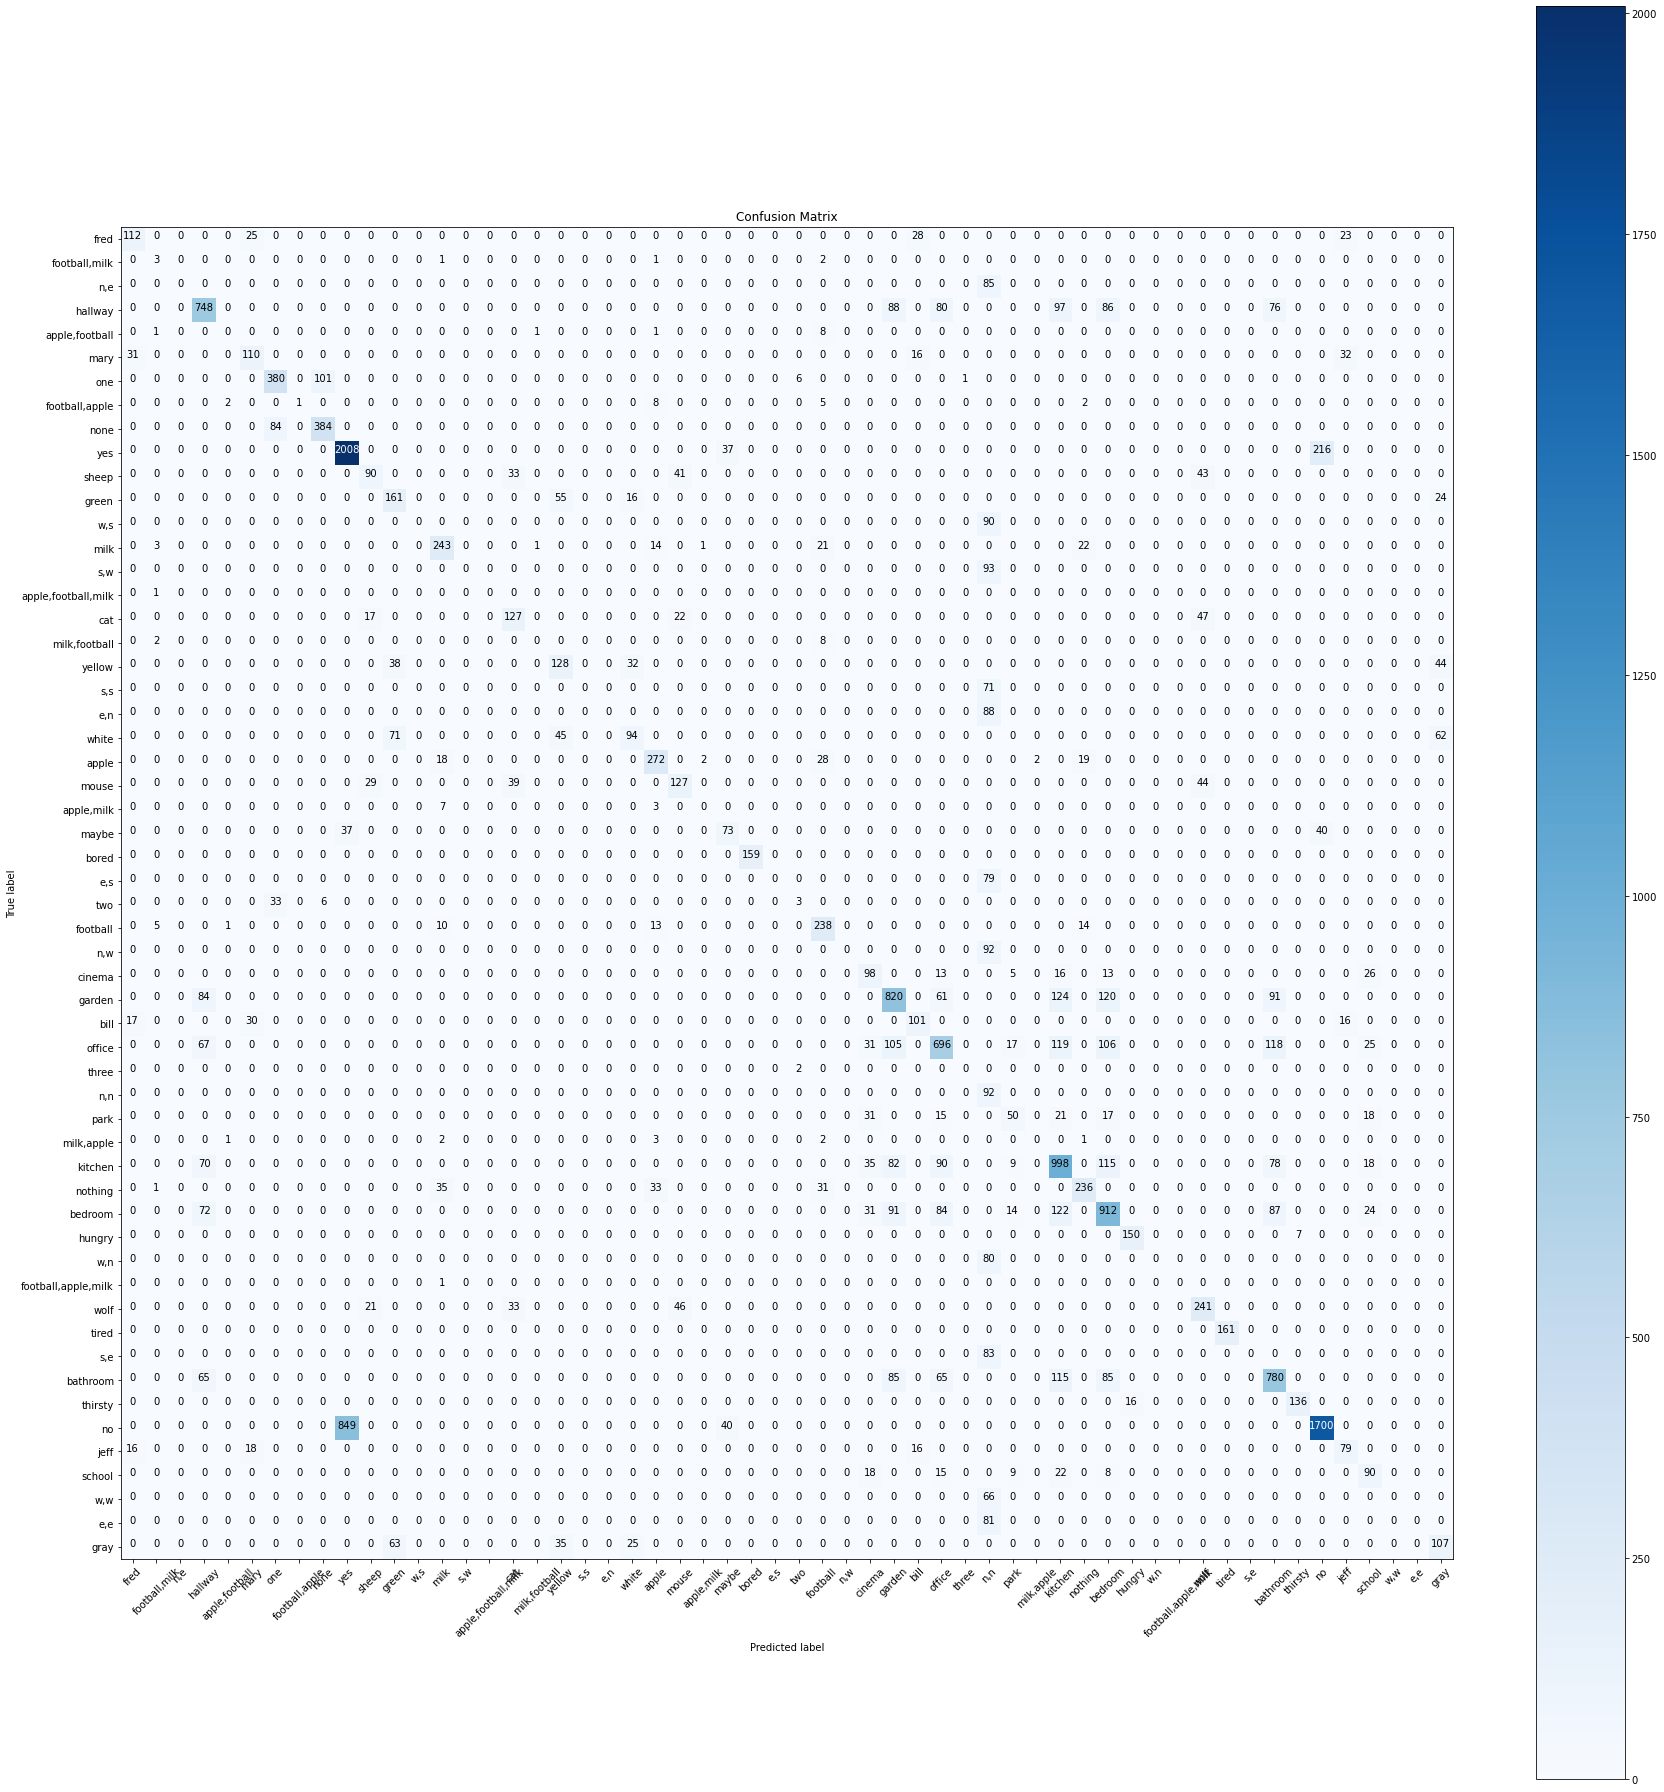

16.33546280860901


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
model.to(device)
checkpoint_name = f'checkpoints/{model_name}/best_checkpoint_{now}.pt'
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)

babi_dataset.set_mode('test')
test_loader = DataLoader(
    babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
)

y_pred_extended = []
y_true_extended = []
y_pred_task = [[] for _ in range(20)]
y_true_task = [[] for _ in range(20)]

start = time.time()
with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(test_loader, desc=f"Inference")):
        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)

        logits = torch.squeeze(model(torch.cat((contexts, questions), 1))).cpu()
        # We consider a task successfully passed if ≥ 95% accuracy is obtained.
        y_pred = m(logits)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [babi_dataset.QA.IVOCAB[int(i)] for i in y_pred]
        y_true = [babi_dataset.QA.IVOCAB[int(i)] for i in answers.cpu()]
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_true)
        for i in range(len(y_pred)):
            y_pred_task[int(tasks[i]) - 1].append(y_pred[i])
            y_true_task[int(tasks[i]) - 1].append(y_true[i])
end = time.time()

        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
task_acc = []
passed_tasks = []
for i in range(20):
    task_acc.append(accuracy_score(y_pred_task[i], y_true_task[i]))
    passed_tasks.append(1 if task_acc[i] >= 0.95 else 0)
print(task_acc)
print('passed_tasks:', passed_tasks)
print('no. passed_tasks:', sum(passed_tasks))
labels = list(set(y_true_extended).intersection(set(y_true_extended)))
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended, labels)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, title = ('Confusion Matrix'))
plt.show()
print(end-start)

In [ ]:
# from thop import profile
# from thop import clever_format

# macs, params = profile(model, inputs=(
#                         torch.randint(1, size=(1, 910)).type(torch.LongTensor).to(device), 
#                         torch.randint(1, size=(1, 13)).type(torch.LongTensor).to(device)))  # , 
# #                         custom_ops={YourModule: count_your_model})

# macs, params = clever_format([macs, params], "%.3f")
# print(macs, params)

In [ ]:
# model.layers.append(model.layers[1])
print(len(model.layers))